In [73]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Activation, LeakyReLU
import pandas as pd
from keras.models import Sequential
from keras.optimizers import Adam


In [74]:
MNIST_train = torchvision.datasets.MNIST(root="./data",  download=True)
MNIST_test = torchvision.datasets.MNIST(root="./data", train=False,  download=True)

In [75]:

def onehot_encoding(labels):
    classes = [0,1,2,3,4,5,6,7,8,9]
    one_hot = np.identity(len(classes))
    temp = []
    for label in labels:
        index = classes.index(label)
        temp.append(one_hot[index])
    dataset_onehot = np.array(temp)
    return dataset_onehot
    
x_train = []
y_train = []
for s in MNIST_train:
    image = s[0]
    label = s[1]
    x_train.append(np.array(image))
    y_train.append(np.array(label))
x_train = np.array(x_train)
y_train = np.array(y_train)

In [76]:
y_train = onehot_encoding(y_train)
x_train = np.reshape(x_train, (60000, 28, 28, 1))
print(np.array(y_train).shape)
print(np.array(x_train).shape)

(60000, 10)
(60000, 28, 28, 1)


In [77]:
x_test = []
y_test = []
for s in MNIST_test:
    image = s[0]
    label = s[1]
    x_test.append(np.array(image))
    y_test.append(np.array(label))
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test = onehot_encoding(y_test)
x_test = np.reshape(x_test, (10000, 28, 28, 1))
print(np.array(y_test).shape)
print(np.array(x_test).shape)

(10000, 10)
(10000, 28, 28, 1)


In [89]:
def define_model():
	model = keras.Sequential()
	model.add(layers.Conv2D(32, 3, strides=1, padding="same", activation="relu", input_shape=(28,28,1)))
	model.add(layers.MaxPooling2D(2))
	model.add(layers.Conv2D(64, 3, strides=1, padding="same", activation="relu"))
	model.add(layers.MaxPooling2D(2))
	model.add(layers.Flatten(name="flattenlayer"))
	model.add(layers.Dense(3136, activation="relu"))
	model.add(layers.Dense(10, activation="softmax"))
	return model
	
model = define_model()


In [90]:
opt = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss="CategoricalCrossentropy")
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
flattenlayer (Flatten)       (None, 3136)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 3136)              9837632   
_________________________________________________________________
dense_25 (Dense)             (None, 10)              

In [91]:
History = model.fit(x_train,y_train,validation_split=0.4,epochs=1)
extractor = keras.Model(inputs=model.inputs,
                        outputs=model.get_layer(name="flattenlayer").output)

1125/1125 [==============================] - 63s 56ms/step - loss: 2.2745 - val_loss: 0.6753


In [92]:
def doPCA(data):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    pca.fit(data[0:5000])
    return pca

In [93]:
intermediate_output = extractor.predict(x_train)
pca = doPCA(intermediate_output)
print(pca.explained_variance_ratio_)
transformed_data = pca.transform(intermediate_output[0:5000])
print(transformed_data[0])

[0.16122562 0.1168893 ]
[ 19.192204 110.871315]


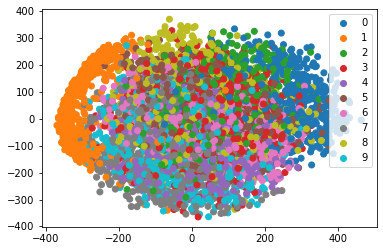

In [95]:
from matplotlib.colors import ListedColormap
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ListedColormap(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", 
          "tab:olive", "tab:cyan"])
values = []
i = 0
for point, label in zip(transformed_data, y_train):
    print(f"[{i}]/[5000]", end="\r", flush=True)
    value = np.argmax(label)
    values.append(value)
    i += 1
scatter = plt.scatter(x=transformed_data[:, 0], y=transformed_data[:, 1], c=values, cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)